In [1]:
#Modified from https://scipython.com/blog/the-spring-pendulum/

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import animation
import os
from IPython.display import Video


In [2]:
# Pendulum equilibrium spring length (m), spring constant (N.m)
L_eq, k = 1, 40
L_init = 1
m = 1
# The gravitational acceleration (m.s-2).
g = 9.81

# Maximum time, time point spacings and the time grid (all in s).
tmax, dt = 20, 0.01
t = np.arange(0, tmax+dt, dt)
# Initial conditions: theta, dtheta/dt, L, dL/dt
y0 = [3*np.pi/4, 0, L_init, 0]


In [55]:
class Pendulum_Spring:
    def __init__(self):
        # Pendulum equilibrium spring length (m), spring constant (N.m)
        self.L_eq = 1
        self.k = 100
        
        self.m = 1
        self.g = 9.81
        
        self.L_init = 1
        self.theta_init = 3*np.pi/4
        
        self.tmax = 5

        
    def deriv(self,y, t, L_eq, k, m,g):
        """Return the first derivatives of y = theta, z1, L, z2."""
        theta, z1, L, z2 = y

        thetadot = z1
        z1dot = (-g*np.sin(theta) - 2*z1*z2) / L
        Ldot = z2
        z2dot = (m*L*z1**2 - k*(L-L_eq) + m*g*np.cos(theta)) / m
        return thetadot, z1dot, Ldot, z2dot

    def plot_spring(self,x, y, theta, L):
        """Plot the spring from (0,0) to (x,y) as the projection of a helix."""
        # Spring turn radius, number of turns
        rs, ns = 0.05, 25
        # Number of data points for the helix
        Ns = 1000
        # We don't draw coils all the way to the end of the pendulum:
        # pad a bit from the anchor and from the bob by these number of points
        ipad1, ipad2 = 100, 150
        w = np.linspace(0, L, Ns)
        # Set up the helix along the x-axis ...
        xp = np.zeros(Ns)
        xp[ipad1:-ipad2] = rs * np.sin(2*np.pi * ns * w[ipad1:-ipad2] / L)
        # ... then rotate it to align with  the pendulum and plot.
        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        xs, ys = - R @ np.vstack((xp, w))
        self.ax1.plot(xs, ys, c='k', lw=2)

    def make_plot(self,i):
        """
        Plot and save an image of the spring pendulum configuration for time
        point i.

        """

        if not(os.path.exists('frames')):
            os.mkdir('frames')

        self.plot_spring(self.x[i], self.y[i], self.theta[i], self.L[i])
        # Circles representing the anchor point of rod 1 and the bobs
        c0 = Circle((0, 0), self.r/2, fc='k', zorder=10)
        c1 = Circle((self.x[i], self.y[i]), self.r, fc='r', ec='r', zorder=10)
        self.ax1.add_patch(c0)
        self.ax1.add_patch(c1)

        # The trail will be divided into ns segments and plotted as a fading line.
        ns = 20
        s = self.max_trail // ns

        for j in range(ns):
            imin = i - (ns-j)*s
            if imin < 0:
                continue
            imax = imin + s + 1
            # The fading looks better if we square the fractional length along the
            # trail.
            alpha = (j/ns)**2
            self.ax1.plot(self.x[imin:imax], self.y[imin:imax], c='r', solid_capstyle='butt',
                    lw=2, alpha=alpha)

        # Centre the image on the fixed anchor point, and ensure the axes are equal
        self.ax1.set_xlim(-np.max(self.L)-self.r, np.max(self.L)+self.r)
        self.ax1.set_ylim(-np.max(self.L)-self.r, np.max(self.L)+self.r)
        self.ax1.set_aspect('equal', adjustable='box')
        plt.axis('off')
        plt.savefig('frames/_img{:04d}.png'.format(i//self.di), dpi=72)
        # Clear the Axes ready for the next image.
        plt.cla()
        
    def experiment_animate(self):
        # Make an image every di time points, corresponding to a frame rate of fps
        # frames per second.
        # Frame rate, s-1
        fps = 10
        self.di = int(1/fps/self.dt)
        # This figure size (inches) and dpi give an image of 600x450 pixels.
        self.fig1 = plt.figure(figsize=(8.33333333, 6.25), dpi=72)
        self.ax1 = self.fig1.add_subplot(111)

        for i in range(0, self.t.size, self.di):
            print(i // self.di, '/', self.t.size // self.di)
            self.make_plot(i)

        fig_anim = plt.figure()
        ims = []
        for i in range(0, self.t.size, self.di):
            frame = plt.imread('frames/_img{:04d}.png'.format(i//self.di))

            ax = fig_anim.gca()
            im = ax.imshow(frame, animated=True)

            ax.grid(True)
            ax.axis('off')
            #ax.spines['left'].set_position('center')
            #ax.spines['right'].set_color('none')
            #ax.spines['bottom'].set_position('center')
            #ax.spines['top'].set_color('none')

            ims.append([im])

        ani = animation.ArtistAnimation(fig_anim, ims, interval=50, blit=True,
                                        repeat_delay=1000)
        ani.save(self.video_output_filename)
        #plt.show()
        
    def run_experiment(self):
        # Maximum time, time point spacings and the time grid (all in s).
        self.dt = 0.005
        self.t = np.arange(0, self.tmax+self.dt, self.dt)
        # Initial conditions: theta, dtheta/dt, L, dL/dt
        y0 = [self.theta_init, 0, self.L_init, 0]
        
        # Do the numerical integration of the equations of motion
        y = odeint(self.deriv, y0, self.t, args=(self.L_eq, self.k, self.m,self.g))
        # Unpack z and theta as a function of time
        self.theta, self.L = y[:,0], y[:,2]

        # Convert to Cartesian coordinates of the two bob positions.
        self.x = self.L * np.sin(self.theta)
        self.y = -self.L * np.cos(self.theta)

        # Plotted bob circle radius
        self.r = 0.05
        # Plot a trail of the m2 bob's position for the last trail_secs seconds.
        trail_secs = 1
        # This corresponds to max_trail time points.
        self.max_trail = int(trail_secs / self.dt)
        
        self.experiment_animate()
        
        





    

0 / 500
1 / 500
2 / 500
3 / 500
4 / 500
5 / 500
6 / 500
7 / 500
8 / 500
9 / 500
10 / 500
11 / 500
12 / 500
13 / 500
14 / 500
15 / 500
16 / 500
17 / 500
18 / 500
19 / 500
20 / 500
21 / 500
22 / 500
23 / 500
24 / 500
25 / 500
26 / 500
27 / 500
28 / 500
29 / 500
30 / 500
31 / 500
32 / 500
33 / 500
34 / 500
35 / 500
36 / 500
37 / 500
38 / 500
39 / 500
40 / 500
41 / 500
42 / 500
43 / 500
44 / 500
45 / 500
46 / 500
47 / 500
48 / 500
49 / 500
50 / 500
51 / 500
52 / 500
53 / 500
54 / 500
55 / 500
56 / 500
57 / 500
58 / 500
59 / 500
60 / 500
61 / 500
62 / 500
63 / 500
64 / 500
65 / 500
66 / 500
67 / 500
68 / 500
69 / 500
70 / 500
71 / 500
72 / 500
73 / 500
74 / 500
75 / 500
76 / 500
77 / 500
78 / 500
79 / 500
80 / 500
81 / 500
82 / 500
83 / 500
84 / 500
85 / 500
86 / 500
87 / 500
88 / 500
89 / 500
90 / 500
91 / 500
92 / 500
93 / 500
94 / 500
95 / 500
96 / 500
97 / 500
98 / 500
99 / 500
100 / 500
101 / 500
102 / 500
103 / 500
104 / 500
105 / 500
106 / 500
107 / 500
108 / 500
109 / 500
110 / 500


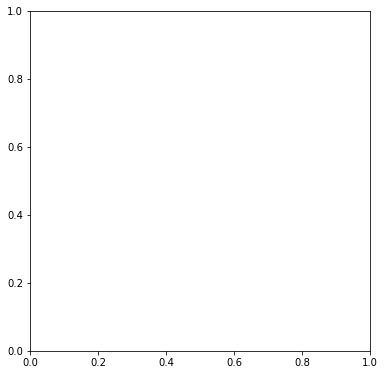

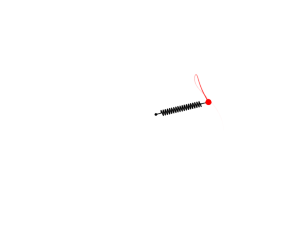

In [56]:
#Default
system = Pendulum_Spring()

system.tmax=50

system.video_output_filename = "experiment1.mp4"
system.run_experiment()

system1 = system

In [57]:
Video("experiment1.mp4")

In [61]:
len(system.theta)

10001

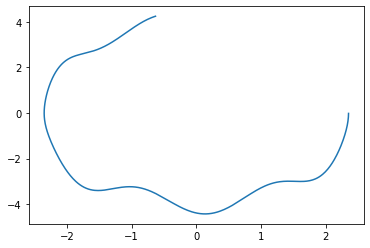

In [66]:
system = system1

fig = plt.figure()
ax = fig.add_subplot(111)

a = system.theta[:500]
#b = system.L
b = np.gradient(system.theta,system.t)[:500]

ax.plot(a,b)

plt.show()

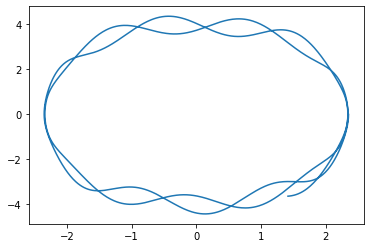

In [65]:
system = system1

fig = plt.figure()
ax = fig.add_subplot(111)

a = system.theta[:1520]
#b = system.L
b = np.gradient(system.theta,system.t)[:1520]

ax.plot(a,b)

plt.show()

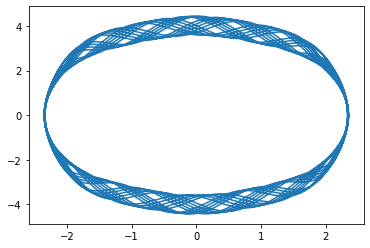

In [59]:
system = system1

fig = plt.figure()
ax = fig.add_subplot(111)

a = system.theta
#b = system.L
b = np.gradient(system.theta,system.t)

ax.plot(a,b)

plt.show()

0 / 50
1 / 50
2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
50 / 50


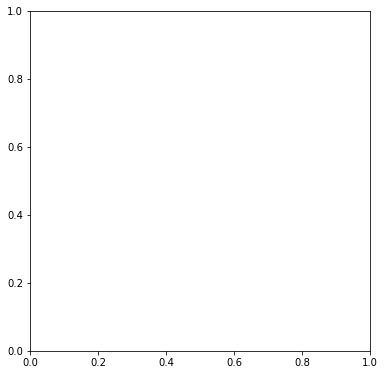

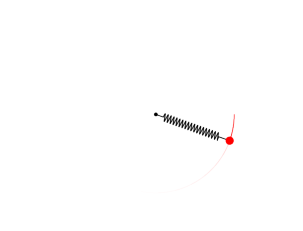

In [8]:
#Rigid Spring Limit=Single Pendulum
#Large Amplitude
system = Pendulum_Spring()
system.L_eq = 1
system.k = 1e6

system.m = 1
system.g = 9.81

system.L_init = 1
system.theta_init = np.pi/2

system.video_output_filename = "experiment2.mp4"
system.run_experiment()

system2 = system

In [9]:
Video("experiment2.mp4")

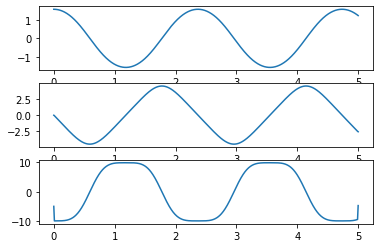

In [10]:
system = system2

fig = plt.figure()
ax_pos = fig.add_subplot(311)
ax_vel = fig.add_subplot(312)
ax_acc = fig.add_subplot(313)

pos = system.theta
vel = np.gradient(pos,system.t)
acc = np.gradient(vel,system.t)

pos_mean = np.mean(pos)
vel_mean = np.mean(vel)
acc_mean = np.mean(acc)

pos_amp = np.max(pos)-np.mean(pos)
vel_amp = np.max(vel)-np.mean(vel)
acc_amp = np.max(acc)-np.mean(acc)

ax_pos.plot(system.t,pos)
ax_vel.plot(system.t,vel)
ax_acc.plot(system.t,acc)

plt.show()

0 / 50
1 / 50
2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
50 / 50


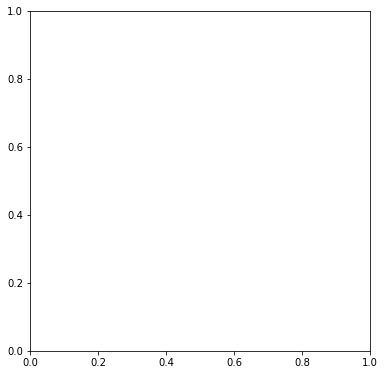

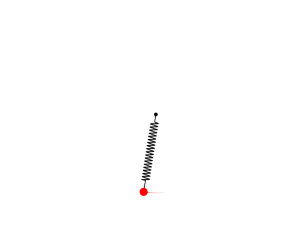

In [11]:
#Rigid Spring Limit=Single Pendulum
#Small amplitude
system = Pendulum_Spring()
system.L_eq = 1
system.k = 1e6

system.m = 1
system.g = 9.81

system.L_init = 1
system.theta_init = np.pi/20

system.video_output_filename = "experiment22.mp4"
system.run_experiment()

system22 = system

In [12]:
Video("experiment22.mp4")

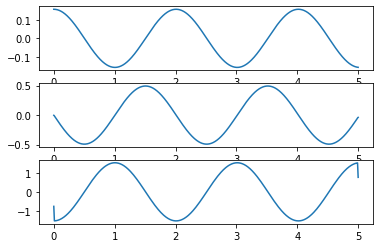

In [13]:
fig = plt.figure()
ax_pos = fig.add_subplot(311)
ax_vel = fig.add_subplot(312)
ax_acc = fig.add_subplot(313)

pos = system.theta
vel = np.gradient(pos,system.t)
acc = np.gradient(vel,system.t)

pos_mean = np.mean(pos)
vel_mean = np.mean(vel)
acc_mean = np.mean(acc)

pos_amp = np.max(pos)-np.mean(pos)
vel_amp = np.max(vel)-np.mean(vel)
acc_amp = np.max(acc)-np.mean(acc)

ax_pos.plot(system.t,pos)
ax_vel.plot(system.t,vel)
ax_acc.plot(system.t,acc)

plt.show()

0 / 50
1 / 50
2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
50 / 50


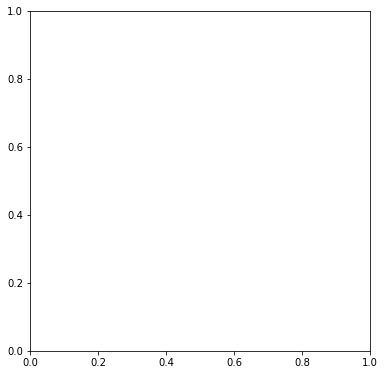

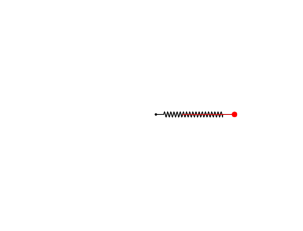

In [14]:
#Horizontal Spring
system = Pendulum_Spring()
system.L_eq = 1
system.k = 100

system.m = 1
system.g = 0

system.L_init = 1.5
system.theta_init = np.pi/2

system.video_output_filename = "experiment3.mp4"
system.run_experiment()

system3 = system

In [15]:
Video("experiment3.mp4")

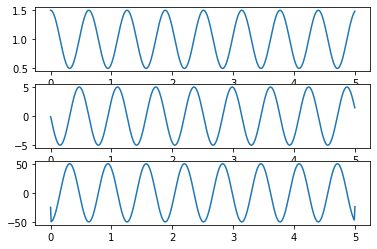

In [32]:
fig = plt.figure()
ax_pos = fig.add_subplot(311)
ax_vel = fig.add_subplot(312)
ax_acc = fig.add_subplot(313)

system = system3

pos = system.x
vel = np.gradient(pos,system.t)
acc = np.gradient(vel,system.t)

pos_mean = np.mean(pos)
vel_mean = np.mean(vel)
acc_mean = np.mean(acc)

pos_amp = np.max(pos)-np.mean(pos)
vel_amp = np.max(vel)-np.mean(vel)
acc_amp = np.max(acc)-np.mean(acc)

ax_pos.plot(system.t,pos)
ax_vel.plot(system.t,vel)
ax_acc.plot(system.t,acc)

plt.show()

In [35]:
print(pos[:200])
print(system.t[:200])

[1.5        1.49937513 1.4975021  1.49438557 1.49003334 1.48445627
 1.47766829 1.46968641 1.46053054 1.4502236  1.43879132 1.4262623
 1.41266785 1.39804193 1.38242112 1.36584446 1.34835338 1.3299916
 1.31080501 1.29084156 1.27015117 1.24878554 1.22679807 1.20424373
 1.18117888 1.15766118 1.13374942 1.10950334 1.08498357 1.06025138
 1.0353686  1.01039741 0.98540023 0.96043955 0.93557774 0.91087696
 0.88639894 0.86220486 0.8383552  0.81490956 0.79192656 0.76946363
 0.74757692 0.72632114 0.70574941 0.68591316 0.66686196 0.64864343
 0.63130311 0.61488434 0.59942815 0.58497319 0.57155558 0.55920886
 0.54796389 0.53784877 0.52888879 0.52110634 0.51452087 0.50914885
 0.50500371 0.50209579 0.50043238 0.50001762 0.50085257 0.50293512
 0.50626007 0.51081911 0.51660086 0.52359085 0.53177161 0.5411227
 0.55162075 0.56323951 0.57594994 0.58972028 0.6045161  0.62030043
 0.63703381 0.65467442 0.67317816 0.69249878 0.712588   0.73339559
 0.75486956 0.77695623 0.79960039 0.82274545 0.84633355 0.8703057

In [36]:
print(system.t[1+np.argmax(pos[1:200])])

0.63


0 / 50
1 / 50
2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
50 / 50


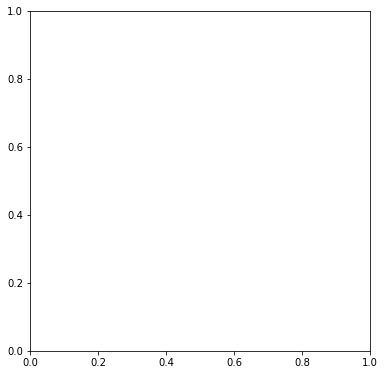

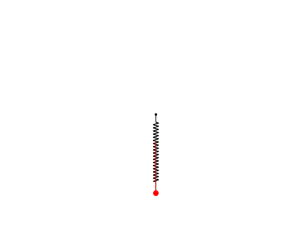

In [19]:
#Vertical Spring
system = Pendulum_Spring()
system.L_eq = 1
system.k = 100

system.m = 1
system.g = 0

system.L_init = 1.5
system.theta_init = 0

system.video_output_filename = "experiment4.mp4"
system.run_experiment()

system4 = system

In [20]:
Video("experiment4.mp4")

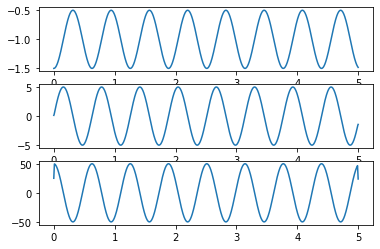

In [43]:
fig = plt.figure()
ax_pos = fig.add_subplot(311)
ax_vel = fig.add_subplot(312)
ax_acc = fig.add_subplot(313)

system = system4

pos = system.y
vel = np.gradient(pos,system.t)
acc = np.gradient(vel,system.t)

pos_mean = np.mean(pos)
vel_mean = np.mean(vel)
acc_mean = np.mean(acc)

pos_amp = np.max(pos)-np.mean(pos)
vel_amp = np.max(vel)-np.mean(vel)
acc_amp = np.max(acc)-np.mean(acc)

ax_pos.plot(system.t,pos)
ax_vel.plot(system.t,vel)
ax_acc.plot(system.t,acc)

plt.show()

In [44]:
print(pos_mean)

-0.99787016534483


In [45]:
print(system.t[1+np.argmin(pos[1:200])])

0.63


0 / 50
1 / 50
2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
50 / 50


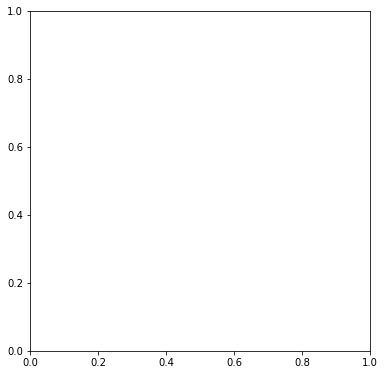

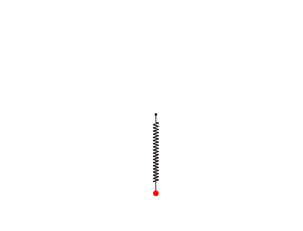

In [23]:
#Vertical Spring with gravity
system = Pendulum_Spring()
system.L_eq = 1
system.k = 100

system.m = 1
system.g = 9.81

system.L_init = 1.5
system.theta_init = 0

system.video_output_filename = "experiment5.mp4"
system.run_experiment()

system5 = system

In [24]:
Video("experiment5.mp4")

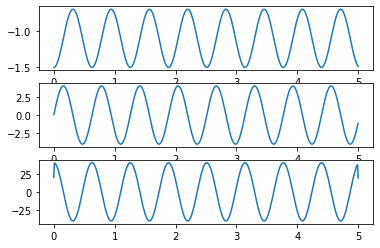

In [38]:
fig = plt.figure()
ax_pos = fig.add_subplot(311)
ax_vel = fig.add_subplot(312)
ax_acc = fig.add_subplot(313)

system=system5

pos = system.y
vel = np.gradient(pos,system.t)
acc = np.gradient(vel,system.t)

pos_mean = np.mean(pos)
vel_mean = np.mean(vel)
acc_mean = np.mean(acc)

pos_amp = np.max(pos)-np.mean(pos)
vel_amp = np.max(vel)-np.mean(vel)
acc_amp = np.max(acc)-np.mean(acc)

ax_pos.plot(system.t,pos)
ax_vel.plot(system.t,vel)
ax_acc.plot(system.t,acc)

plt.show()

In [39]:
print(pos_mean)

-1.0963880374520343


In [40]:
print(pos_amp)
print(vel_amp)
print(acc_amp)

0.40017659027359087
4.015016502492114
40.386983637855444


In [42]:
print(system.t[1+np.argmin(pos[1:200])])

0.63


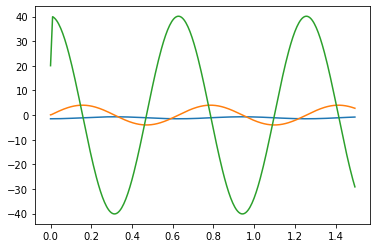

In [28]:
fig = plt.figure()
ax_all = fig.add_subplot(111)

trunc = 300

system=system5

ax_all.plot(system.t[:trunc],system.y[:trunc])
ax_all.plot(system.t[:trunc],vel[:trunc])
ax_all.plot(system.t[:trunc],acc[:trunc])

plt.show()

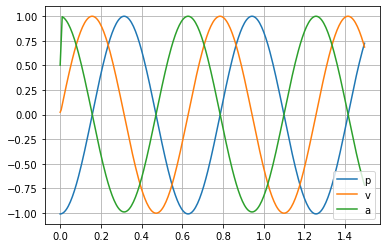

In [29]:
fig = plt.figure()
ax_all = fig.add_subplot(111)

trunc = 300

system=system5

ax_all.plot(system.t[:trunc],((pos-pos_mean)/pos_amp)[:trunc],label="p")
ax_all.plot(system.t[:trunc],((vel-vel_mean)/vel_amp)[:trunc],label="v")
ax_all.plot(system.t[:trunc],((acc-acc_mean)/acc_amp)[:trunc],label="a")

ax_all.grid('on')
ax_all.legend()

plt.show()